### Select index components & import data
In this chapter, you will begin to work on a case study that requires many of your new time series skills. You will build an important tool to measure aggregate stock performance, used by stock exchanges (like the S&P 500) or for investor portfolios.


More specifically, you will build an index that will be composed of several stock prices, and each component of the index will be weighted by its market capitalization. The market capitalization is the the value of all the stocks of a company: just multiply the stock price by the number of stocks in the market. So each stock is weighted by the value of the company on the stock market. This is called a value-weighted index. As a result, larger companies receive a larger weight, and their price changes will have a larger impact on the index performance. Many key indexes are based on market capitalization, including the S&P 500, the NASDAQ composite, or the Hang Seng index of the Hong Kong stock exchange.

In [1]:
#libraries
import pandas as pd 
import numpy as np
import seaborn as sns
from numpy.random import normal, seed, choice
from scipy.stats import norm
from datetime import datetime #To manually create dates
import matplotlib.pyplot as plt
import xlwt

In [2]:
#read listings and join sheets
listings=pd.concat(pd.read_excel('Datasets/Stock_data-/listings.xlsx', sheet_name=None), ignore_index=True)
pd.options.display.float_format = '{:.0f}'.format #Suppress Scientific Format in a Dataframe Column
pd.options.display.float_format = '{:,}'.format #Format a number with commas to separate thousands
listings.info()

c:\Users\Yira\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\Yira\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6674 entries, 0 to 6673
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Stock Symbol           6674 non-null   object 
 1   Company Name           6674 non-null   object 
 2   Last Sale              6590 non-null   float64
 3   Market Capitalization  6674 non-null   float64
 4   IPO Year               2852 non-null   float64
 5   Sector                 5182 non-null   object 
 6   Industry               5182 non-null   object 
dtypes: float64(3), object(4)
memory usage: 365.1+ KB


c:\Users\Yira\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [3]:
listings.head()

,Stock Symbol,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry
0,XXII,"22nd Century Group, Inc",1.33,"120,628,490.29",NaN,Consumer Non-Durables,Farming/Seeds/Milling
1,FAX,Aberdeen Asia-Pacific Income Fund Inc,5.0,"1,266,332,595.0","1,986.0",NaN,NaN
2,IAF,Aberdeen Australia Equity Fund Inc,6.15,"139,865,304.9",NaN,NaN,NaN
3,CH,"Aberdeen Chile Fund, Inc.",7.2201,"67,563,457.56899999",NaN,NaN,NaN
4,ABE,Aberdeen Emerging Markets Smaller Company Oppo...,13.36,"128,842,971.6",NaN,NaN,NaN


In [4]:
#Move the column 'Stock Symbol' into the index (inplace).
listings.set_index('Stock Symbol', inplace=True)
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6674 entries, XXII to ZTO
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Company Name           6674 non-null   object 
 1   Last Sale              6590 non-null   float64
 2   Market Capitalization  6674 non-null   float64
 3   IPO Year               2852 non-null   float64
 4   Sector                 5182 non-null   object 
 5   Industry               5182 non-null   object 
dtypes: float64(3), object(3)
memory usage: 365.0+ KB


In [5]:
#Drop all companies with missing 'Sector' information from listings
listings.dropna(subset=['Sector'], inplace=True)
listings.head()

,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry
Stock Symbol,,,,,,
XXII,"22nd Century Group, Inc",1.33,"120,628,490.29",NaN,Consumer Non-Durables,Farming/Seeds/Milling
ACU,Acme United Corporation.,27.39,"91,138,992.45","1,988.0",Capital Goods,Industrial Machinery/Components
AIII,"ACRE Realty Investors, Inc.",1.16,"23,768,939.4",NaN,Consumer Services,Real Estate Investment Trusts
ATNM,"Actinium Pharmaceuticals, Inc.",1.47,"82,037,380.74",NaN,Health Care,Major Pharmaceuticals
AE,"Adams Resources & Energy, Inc.",37.8,"159,425,128.8",NaN,Energy,Oil Refining/Marketing


In [6]:
#Select companies with IPO Year before 2019
listings = listings[listings['IPO Year'] < 2019]
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2349 entries, ACU to ZTO
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Company Name           2349 non-null   object 
 1   Last Sale              2349 non-null   float64
 2   Market Capitalization  2349 non-null   float64
 3   IPO Year               2349 non-null   float64
 4   Sector                 2349 non-null   object 
 5   Industry               2349 non-null   object 
dtypes: float64(3), object(3)
memory usage: 128.5+ KB


In [7]:
listings.head()

,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry
Stock Symbol,,,,,,
ACU,Acme United Corporation.,27.39,"91,138,992.45","1,988.0",Capital Goods,Industrial Machinery/Components
AAU,"Almaden Minerals, Ltd.",1.72,"154,891,744.8","2,015.0",Basic Industries,Precious Metals
USAS,Americas Silver Corporation,3.05,"120,694,837.9","2,017.0",Basic Industries,Precious Metals
AINC,Ashford Inc.,57.3373,"115,550,771.2813","2,014.0",Consumer Services,Professional Services
AUXO,"Auxilio, Inc.",6.3043,"59,131,036.8511","2,017.0",Miscellaneous,Business Services


In [8]:
#Show the number of companies per 'Sector' using .groupby() and .size(). Sort the output in descending order
print(listings.groupby('Sector').size().sort_values(ascending=False))


Sector
Health Care              445
Consumer Services        402
Technology               386
Finance                  351
Energy                   144
Capital Goods            143
Basic Industries         104
Public Utilities         104
Consumer Non-Durables     89
Miscellaneous             68
Transportation            58
Consumer Durables         55
dtype: int64


data is squeaky clean now

#### Select and inspect index components
Now that you have imported and cleaned the listings data, you can proceed to select the index components as the largest company for each sector by market capitalization.

You'll also have the opportunity to take a closer look at the components, their last market value, and last price.

In [9]:
#Use .groupby() and .nlargest() to select the largest company by 'Market Capitalization' for each 'Sector', and assign the result to components
components = listings.groupby(["Sector"])['Market Capitalization'].nlargest(1)
components

Sector                 Stock Symbol
Basic Industries       RIO             70,431,476,895.12
Capital Goods          GM              50,086,335,099.15
Consumer Durables      CPRT             13,620,922,869.4
Consumer Non-Durables  ABEV            88,240,198,455.36
Consumer Services      AMZN           422,138,530,626.06
Energy                 PAA             22,223,001,415.68
Finance                GS              88,840,590,477.48
Health Care            AMGN           118,927,210,535.31
Miscellaneous          BABA            275,525,000,000.0
Public Utilities       TEF              54,609,806,091.6
Technology             AAPL            740,024,467,000.0
Transportation         UPS             90,180,886,755.96
Name: Market Capitalization, dtype: float64

In [10]:
#Print components, sorted in descending order by market cap.
print(components.sort_values(ascending=False))

Sector                 Stock Symbol
Technology             AAPL            740,024,467,000.0
Consumer Services      AMZN           422,138,530,626.06
Miscellaneous          BABA            275,525,000,000.0
Health Care            AMGN           118,927,210,535.31
Transportation         UPS             90,180,886,755.96
Finance                GS              88,840,590,477.48
Consumer Non-Durables  ABEV            88,240,198,455.36
Basic Industries       RIO             70,431,476,895.12
Public Utilities       TEF              54,609,806,091.6
Capital Goods          GM              50,086,335,099.15
Energy                 PAA             22,223,001,415.68
Consumer Durables      CPRT             13,620,922,869.4
Name: Market Capitalization, dtype: float64


In [11]:
#Select Stock Symbol from the index of components, assign it to tickers and print the result
tickers = components.index.get_level_values("Stock Symbol")
tickers

Index(['RIO', 'GM', 'CPRT', 'ABEV', 'AMZN', 'PAA', 'GS', 'AMGN', 'BABA', 'TEF',
       'AAPL', 'UPS'],
      dtype='object', name='Stock Symbol')

In [12]:
# Create a list info_cols that holds the column names Company Name, Market Capitalization, and Last Sale. 
# Next, use .loc[] with tickers and info_cols to print() more details about the listings sorted in descending order by Market Capitalization).
info_cols = ["Company Name","Market Capitalization","Last Sale"]
info_cols = listings.loc[tickers, info_cols].sort_values('Market Capitalization', ascending=False)
print(info_cols)

                                    Company Name  Market Capitalization  \
Stock Symbol                                                              
AAPL                                  Apple Inc.      740,024,467,000.0   
AMZN                            Amazon.com, Inc.     422,138,530,626.06   
BABA               Alibaba Group Holding Limited      275,525,000,000.0   
AMGN                                  Amgen Inc.     118,927,210,535.31   
UPS                  United Parcel Service, Inc.      90,180,886,755.96   
GS               Goldman Sachs Group, Inc. (The)      88,840,590,477.48   
ABEV                                  Ambev S.A.      88,240,198,455.36   
RIO                                Rio Tinto Plc      70,431,476,895.12   
TEF                                Telefonica SA       54,609,806,091.6   
GM                        General Motors Company      50,086,335,099.15   
PAA           Plains All American Pipeline, L.P.      22,223,001,415.68   
CPRT                     

#### Import index component price information
Now you'll use the stock symbols for the companies you selected in the last exercise to calculate returns for each company.

In [13]:
#import 'market_cap_series.csv', parsing the 'Date' column and also setting the 'Date' column as index before assigning the result to stock_prices
stock_prices = pd.read_csv('Datasets/Stock_data-/market_cap_series.csv',parse_dates=['Date'], index_col='Date')
stock_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1761 non-null   float64
 1   AMGN    1761 non-null   float64
 2   AMZN    1761 non-null   float64
 3   CPRT    1761 non-null   float64
 4   EL      1762 non-null   float64
 5   GS      1762 non-null   float64
 6   ILMN    1761 non-null   float64
 7   MA      1762 non-null   float64
 8   PAA     1762 non-null   float64
 9   RIO     1762 non-null   float64
 10  TEF     1762 non-null   float64
 11  UPS     1762 non-null   float64
dtypes: float64(12)
memory usage: 179.0 KB


In [14]:
stock_prices.head()

,AAPL,AMGN,AMZN,CPRT,EL,GS,ILMN,MA,PAA,RIO,TEF,UPS
Date,,,,,,,,,,,,
2010-01-04,"160,386.7278","42,475.58067012","63,893.145750200005","2,090.2259378","8,892.66915432","68,854.24234212001","4,469.464999999998","28,476.143688","19,531.934838","101,342.46662644","143,829.33246450004","50,575.70841972001"
2010-01-05,"160,701.5202","42,107.63558462","64,270.11053842","2,090.2259378","8,859.692630880001","70,071.56370546","4,440.204999999999","28,398.521801","19,748.9563362","102,916.0512412","143,728.57636470004","50,662.63813512001"
2010-01-06,"158,130.7156","41,791.20281109","63,105.8142305","2,081.03813148","8,885.341038","69,323.66692014","4,713.785999999998","28,343.077596","19,741.72228626","106,063.22047072","142,217.23486770006","50,288.840358900015"
2010-01-07,"157,815.9232","41,408.539922170006","62,032.18034","2,067.256422","8,998.926840959999","70,680.22438712999","4,794.250999999999","28,154.567299","19,502.99863824","106,081.3076502","139,799.08847250004","49,906.34961114001"
2010-01-08,"158,865.2312","41,776.48500767","63,711.82091536","2,076.44422832","9,035.56742256","69,343.55779209","4,849.844999999998","28,165.65614","19,568.1050877","107,256.9743164","138,892.28357430003","52,305.60975618001"


In [15]:
#Calculate the price return for the index components by dividing the last row of stock_prices by the first, subtracting 1 and multiplying by 100. Assign the result to price_return
price_return = stock_prices.iloc[-1].div(stock_prices.iloc[0]).sub(1).mul(100)
price_return

AAPL     278.8681714098789
AMGN    153.30907830907833
AMZN     460.0224047796862
CPRT    204.39560439560444
EL       215.1627523691801
GS        38.3464293968107
ILMN     319.1162029459902
MA      302.06386292834895
PAA     19.592592592592585
RIO    -31.358200963769413
TEF     -67.77583187390543
UPS      97.04365761430044
dtype: float64

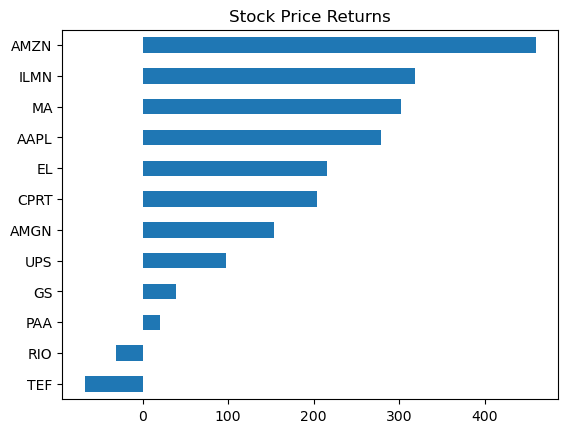

In [16]:
# Plot horizontal bar chart of sorted price_return   
price_return.sort_values().plot(kind='barh', title='Stock Price Returns')
plt.show()

### Build a market-cap weighted index

 To construct the index, you need

1. Build your value-weighted index
to calculate the number of shares using both market capitalization and latest stock price,

2. Build your value-weighted index
because the market capitalization is just the product of the number of shares and the price of each share. Next you'll use the historical stock prices to convert it into a series of market value. Then convert it to an index by normalizing the series to start at 100

#### Calculate number of shares outstanding
The next step towards building a value-weighted index is to calculate the number of shares for each index component.

The number of shares will allow you to calculate the total market capitalization for each component given the historical price series in the next exercise.

In [17]:
# Inspect listings
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2349 entries, ACU to ZTO
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Company Name           2349 non-null   object 
 1   Last Sale              2349 non-null   float64
 2   Market Capitalization  2349 non-null   float64
 3   IPO Year               2349 non-null   float64
 4   Sector                 2349 non-null   object 
 5   Industry               2349 non-null   object 
dtypes: float64(3), object(3)
memory usage: 193.0+ KB


In [18]:
# Inspect first 5 rows of listings
listings.head()

,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry
Stock Symbol,,,,,,
ACU,Acme United Corporation.,27.39,"91,138,992.45","1,988.0",Capital Goods,Industrial Machinery/Components
AAU,"Almaden Minerals, Ltd.",1.72,"154,891,744.8","2,015.0",Basic Industries,Precious Metals
USAS,Americas Silver Corporation,3.05,"120,694,837.9","2,017.0",Basic Industries,Precious Metals
AINC,Ashford Inc.,57.3373,"115,550,771.2813","2,014.0",Consumer Services,Professional Services
AUXO,"Auxilio, Inc.",6.3043,"59,131,036.8511","2,017.0",Miscellaneous,Business Services


In [19]:
#print tickers
tickers

Index(['RIO', 'GM', 'CPRT', 'ABEV', 'AMZN', 'PAA', 'GS', 'AMGN', 'BABA', 'TEF',
       'AAPL', 'UPS'],
      dtype='object', name='Stock Symbol')

In [20]:
#Use .loc[] with the list of tickers to select the index components and the columns 'Market Capitalization' and 'Last Sale'; assign this to components
components = listings.loc[tickers, ['Market Capitalization', 'Last Sale']]
components

,Market Capitalization,Last Sale
Stock Symbol,,
RIO,"70,431,476,895.12",38.94
GM,"50,086,335,099.15",33.39
CPRT,"13,620,922,869.4",29.65
ABEV,"88,240,198,455.36",5.62
AMZN,"422,138,530,626.06",884.67
PAA,"22,223,001,415.68",30.72
GS,"88,840,590,477.48",223.32
AMGN,"118,927,210,535.31",161.61
BABA,"275,525,000,000.0",110.21


In [21]:
#Create no_shares by dividing Market Capitalization by 'Last Sale'
no_shares = components['Market Capitalization'].div(components['Last Sale'])
no_shares

Stock Symbol
RIO        1,808,717,948.0
GM         1,500,039,985.0
CPRT         459,390,316.0
ABEV      15,701,102,928.0
AMZN         477,170,618.0
PAA          723,404,994.0
GS           397,817,439.0
AMGN   735,890,170.9999999
BABA       2,500,000,000.0
TEF        5,037,804,990.0
AAPL       5,246,540,000.0
UPS    869,297,154.0000001
dtype: float64

In [22]:
# Print the sorted no_shares
print(no_shares.sort_values(ascending=False))

Stock Symbol
ABEV      15,701,102,928.0
AAPL       5,246,540,000.0
TEF        5,037,804,990.0
BABA       2,500,000,000.0
RIO        1,808,717,948.0
GM         1,500,039,985.0
UPS    869,297,154.0000001
AMGN   735,890,170.9999999
PAA          723,404,994.0
AMZN         477,170,618.0
CPRT         459,390,316.0
GS           397,817,439.0
dtype: float64


#### Create time series of market value
You can now use the number of shares to calculate the total market capitalization for each component and trading date from the historical price series.

The result will be the key input to construct the value-weighted stock index, which you will complete in the next exercise.

Fists we need to add new information to the "components" dataframe

In [23]:
#data to add
values=[1808.717948,
 146.29999999999998,
 459.390316,
 366.405816,
 477.170618,
 723.404994,
 397.817439,
 735.890171,
 1108.8841,
 5037.8049900000005,
 5246.54,
 869.2971540000001]

In [24]:
#I need the index to joining it in a new dataframe
index=['RIO', 'ILMN', 'CPRT', 'EL', 'AMZN', 'PAA', 'GS', 'AMGN', 'MA', 'TEF', 'AAPL', 'UPS']

In [25]:
#Creating new dataframe with the lists above
new_data=pd.DataFrame(data=zip(index,values),columns=['Stock Symbol','Number of Shares'])
new_data.set_index('Stock Symbol',inplace=True)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, RIO to UPS
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Number of Shares  12 non-null     float64
dtypes: float64(1)
memory usage: 192.0+ bytes


In [26]:
#adding new dataframe to components
new_components=pd.merge(components, new_data, left_index=True, right_index=True)
new_components

,Market Capitalization,Last Sale,Number of Shares
Stock Symbol,,,
RIO,"70,431,476,895.12",38.94,"1,808.717948"
CPRT,"13,620,922,869.4",29.65,459.390316
AMZN,"422,138,530,626.06",884.67,477.170618
PAA,"22,223,001,415.68",30.72,723.404994
GS,"88,840,590,477.48",223.32,397.817439
AMGN,"118,927,210,535.31",161.61,735.890171
TEF,"54,609,806,091.6",10.84,"5,037.8049900000005"
AAPL,"740,024,467,000.0",141.05,"5,246.54"
UPS,"90,180,886,755.96",103.74,869.2971540000001


In [27]:
#Select the 'Number of Shares' from components, assign to no_shares, and print the result, sorted in the default (ascending) order.
no_shares = new_components["Number of Shares"]
print(no_shares.sort_values())

Stock Symbol
GS              397.817439
CPRT            459.390316
AMZN            477.170618
PAA             723.404994
AMGN            735.890171
UPS      869.2971540000001
RIO           1,808.717948
TEF    5,037.8049900000005
AAPL              5,246.54
Name: Number of Shares, dtype: float64


In [28]:
#Multiply stock_prices by no_shares to create a time series of market cap per ticker, and assign it to market_cap
market_cap = stock_prices.mul(no_shares)
market_cap.head()

,AAPL,AMGN,AMZN,CPRT,EL,GS,ILMN,MA,PAA,RIO,TEF,UPS
Date,,,,,,,,,,,,
2010-01-04,"841,475,382.871812","31,257,362.3226589","30,487,931.84358701","960,229.5540773383",NaN,"27,391,418.35282754",NaN,NaN,"14,129,499.204291781","183,299,938.28183302","724,584,128.7980274","43,965,319.390796445"
2010-01-05,"843,126,953.790108","30,986,595.1507717","30,667,808.364546183","960,229.5540773383",NaN,"27,875,690.020031445",NaN,NaN,"14,286,493.639895024","186,146,109.0172461","724,076,539.215682","44,040,887.144991696"
2010-01-06,"829,639,124.6240239","30,753,735.3829487","30,112,240.37576088","956,008.7648286468",NaN,"27,578,163.63625911",NaN,NaN,"14,281,260.49204158","191,838,450.48807228","716,462,695.4805014","43,715,945.80195212"
2010-01-07,"827,987,553.7057279","30,472,137.52418601","29,599,933.82872525","949,677.5809556093",NaN,"28,117,825.853633396",NaN,NaN,"14,108,566.612878013","191,871,165.09422645","704,280,545.5042123","43,383,447.68349302"
2010-01-08,"833,492,790.1000481","30,742,904.696073215","30,401,408.960087653","953,898.370204301",NaN,"27,586,076.571997736",NaN,NaN,"14,155,664.94355899","193,997,614.4942477","699,712,239.2631038","45,469,117.69928192"


In [29]:
#Select the first and the last row of market_cap and assign these to first_value and last_value
first_value = market_cap.iloc[0]
last_value = market_cap.iloc[-1]

In [30]:
#Use pd.concat() to concatenate first_value and last_value along axis=1
join=pd.concat([first_value,last_value],axis=1)
join

,2010-01-04,2016-12-30
AAPL,"841,475,382.871812","3,188,082,395.9507117"
AMGN,"31,257,362.3226589","79,177,736.40325637"
AMZN,"30,487,931.84358701","170,739,249.0780477"
CPRT,"960,229.5540773383","2,922,896.554718931"
EL,NaN,NaN
GS,"27,391,418.35282754","37,895,049.2522796"
ILMN,NaN,NaN
MA,NaN,NaN
PAA,"14,129,499.204291781","16,897,834.41876228"
RIO,"183,299,938.28183302","125,820,375.26895054"


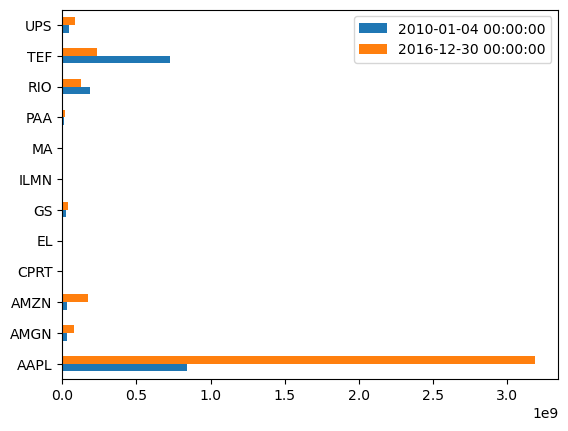

In [31]:
#plot the result as horizontal bar chart.
join.plot(kind='barh')
plt.show()

You've made one of the essential ingredients of the index.

#### Calculate & plot the composite index
By now you have all ingredients that you need to calculate the aggregate stock performance for your group of companies.

Use the time series of market capitalization that you created in the last exercise to aggregate the market value for each period, and then normalize this series to convert it to an index.

In [32]:
#Aggregate the market cap per trading day by applying .sum() to stock_prices with axis=1, assign to raw_index and print the result.
raw_index = stock_prices.sum(axis=1)
print(raw_index)

Date
2010-01-04       694,817.64269122
2010-01-05        697,995.6974754
2010-01-06     694,685.6603107901
2010-01-07     691,241.6137833401
2010-01-08       695,847.58044058
                     ...         
2016-12-23      1,588,874.2543448
2016-12-27     1,599,280.31315686
2016-12-28   1,593,635.2919029803
2016-12-29      1,589,421.9083575
2016-12-30   1,574,861.6250364599
Length: 1762, dtype: float64


In [33]:
#Normalize the aggregate market cap by dividing by the first value of raw_index and multiplying by 100. Assign this to index and print the result.
index2 = raw_index.div(raw_index.iloc[0]).mul(100)
print(index2)

Date
2010-01-04                100.0
2010-01-05    100.4573940828374
2010-01-06    99.98100474537193
2010-01-07    99.48532842458792
2010-01-08     100.148231375555
                    ...        
2016-12-23   228.67500142780668
2016-12-27   230.17266904196717
2016-12-28   229.36022259457775
2016-12-29   228.75382124743285
2016-12-30   226.65826661173818
Length: 1762, dtype: float64


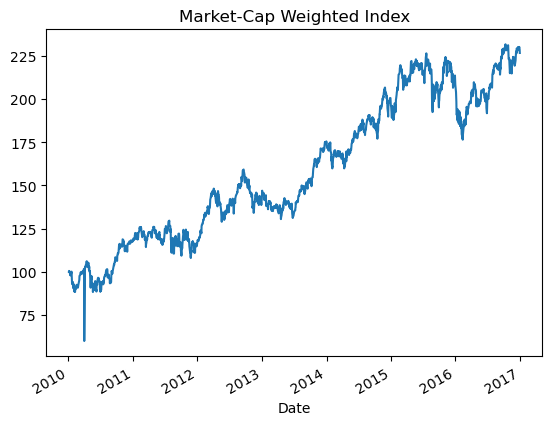

In [34]:
#Plot the index with the title 'Market-Cap Weighted Index
index2.plot(title="Market-Cap Weighted Index")
plt.show()

Now you have an index to work with!

#### Evaluate index performance

Now that you have built a weighted index, you can analyze its performance.

Important elements of your analysis will be: First, take a look at the index return, and the contribution of each component to the result. Next, compare the performance of your index to a benchmark like the S&P 500, which covers the wider market, and is also value weighted. You can compare the overall performance or rolling returns for sub periods

##### Calculate the contribution of each stock to the index
You have successfully built the value-weighted index. Let's now explore how it performed over the 2010-2016 period.

Let's also determine how much each stock has contributed to the index return.

In [35]:
#Divide the last index value by the first, subtract 1 and multiply by 100. Assign the result to index_return and print it
index_return = (index2.iloc[-1]/index2.iloc[0]-1)*100
print(index_return)

126.65826661173818


In [36]:
#Select the 'Market Capitalization' column from components
market_cap = new_components["Market Capitalization"]
market_cap

Stock Symbol
RIO     70,431,476,895.12
CPRT     13,620,922,869.4
AMZN   422,138,530,626.06
PAA     22,223,001,415.68
GS      88,840,590,477.48
AMGN   118,927,210,535.31
TEF      54,609,806,091.6
AAPL    740,024,467,000.0
UPS     90,180,886,755.96
Name: Market Capitalization, dtype: float64

In [37]:
#Calculate the total market cap for all components and assign this to total_market_cap
total_market_cap = market_cap.sum()
total_market_cap

1620996892666.6099

In [38]:
#Divide the components' market cap by total_market_cap to calculate the component weights, assign it to weights, and print weights with the values sorted in default (ascending) order
weights = market_cap/total_market_cap
print(weights.sort_values())

Stock Symbol
CPRT   0.008402806279901618
PAA    0.013709465771474864
TEF    0.033689025770903554
RIO     0.04344948297788355
GS     0.054806144835560656
UPS    0.055632979411582066
AMGN    0.07336671098713188
AMZN     0.2604190868815448
AAPL     0.4565242970840171
Name: Market Capitalization, dtype: float64


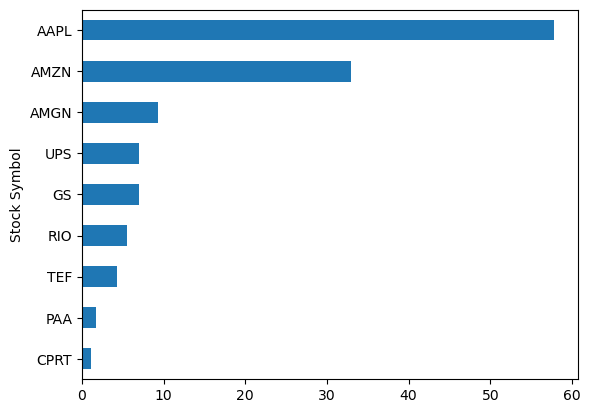

In [39]:
#Multiply weights by the index_return to calculate the contribution by component, sort the values in ascending order, and plot the result as a horizontal bar chart
weights.mul(index_return).sort_values().plot(kind="barh")
plt.show()

The next step is to take a look at how your index stacks up against a benchmark!

#### Compare index performance against benchmark I
The next step in analyzing the performance of your index is to compare it against a benchmark.

In the video, we used the S&P 500 as benchmark. You can also use the Dow Jones Industrial Average, which contains the 30 largest stocks, and would also be a reasonable benchmark for the largest stocks from all sectors across the three exchanges.

In [40]:
#Reading DJIA
djia=pd.read_csv("Datasets/Stock_data-/djia.csv",parse_dates=['date'], index_col='date')
djia.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2610 entries, 2007-06-29 to 2017-06-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   djia    2519 non-null   float64
dtypes: float64(1)
memory usage: 40.8 KB


In [41]:
djia.head()

,djia
date,
2007-06-29,"13,408.62"
2007-07-02,"13,535.43"
2007-07-03,"13,577.3"
2007-07-04,NaN
2007-07-05,"13,565.84"


##### Normalize djia

In [42]:
#First, select the first value of djia
first=djia["djia"].iloc[0]
first

13408.62

In [43]:
#divide by first and mul by 100
djia['djia'] = (djia['djia'].div(first)).mul(100)
djia.head()

,djia
date,
2007-06-29,100.0
2007-07-02,100.94573490784286
2007-07-03,101.25799672151197
2007-07-04,NaN
2007-07-05,101.17252931323281


now we have djia normalize

In [44]:
#Convert index to a pd.DataFrame with the column name 'Index' and assign the result to data
data = index2.to_frame("Index")
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   1762 non-null   float64
dtypes: float64(1)
memory usage: 27.5 KB


In [45]:
#add djia as new column to data.
data_new=data.merge(djia, left_index=True, right_index=True, how='inner')
data_new.head()

,Index,djia
2010-01-04,100.0,78.93399917366588
2010-01-05,100.4573940828374,78.84495197865253
2010-01-06,99.98100474537193,78.85733207444167
2010-01-07,99.48532842458792,79.10478483244361
2010-01-08,100.148231375555,79.1892827151489


In [46]:
#Show the total return for both index and djia by dividing the last row of data by the first, subtracting 1 and multiplying by 100.
print((data_new.iloc[-1] / data_new.iloc[0] -1 ) * 100)
#print((djia.iloc[-1] / djia.iloc[0] -1 ) * 100)

Index   126.65826661173818
djia     86.72217204146652
dtype: float64


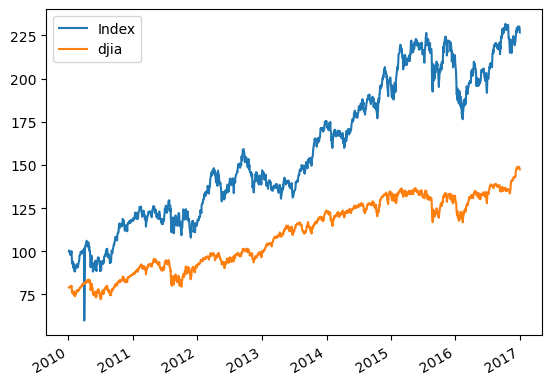

In [47]:
# Plot both series
data_new.plot()
plt.show()

Awesome! How do they compare?

#### Compare index performance against benchmark II
The next step in analyzing the performance of your index is to compare it against a benchmark.

We can also use the Dow Jones Industrial Average, which contains the 30 largest stocks, and would also be a reasonable benchmark for the largest stocks from all sectors across the three exchanges.

In [48]:
#Define a function multi_period_return that takes a numpy array of period returns as input, and returns the total return for the period -
#add 1 to the input, pass the result to np.prod(), subtract 1 and multiply by 100.
def multi_period_return(r):
    return (np.prod(r + 1) - 1) * 100

In [49]:
#Create a .rolling() window of length '360D' from data, and apply multi_period_return. Assign to rolling_return_36
rolling_return_360 = data_new.pct_change().rolling('360D').apply(multi_period_return)
rolling_return_360

,Index,djia
2010-01-04,NaN,NaN
2010-01-05,0.45739408283740346,-0.11281221773323802
2010-01-06,-0.018995254628062508,-0.097128107060096
2010-01-07,-0.5146715754120845,0.21636514121370354
2010-01-08,0.14823137555499688,0.32341392068753194
...,...,...
2016-12-23,7.052685337156328,12.48706335654106
2016-12-27,10.49758517138002,14.462012403995871
2016-12-28,10.107558975432184,13.822931725225152
2016-12-29,12.127498047904828,15.574373693067578


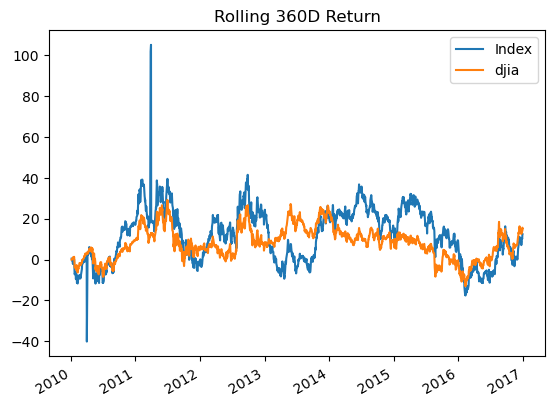

In [50]:
# Plot rolling_return_360 here
rolling_return_360.plot(title='Rolling 360D Return')
plt.show()

#### Visualize your index constituent correlations

To better understand the characteristics of your index constituents, you can calculate the return correlations.

Use the daily stock prices or your index companies, and show a heatmap of the daily return correlations!


In [51]:
#inspect stock prices
stock_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1761 non-null   float64
 1   AMGN    1761 non-null   float64
 2   AMZN    1761 non-null   float64
 3   CPRT    1761 non-null   float64
 4   EL      1762 non-null   float64
 5   GS      1762 non-null   float64
 6   ILMN    1761 non-null   float64
 7   MA      1762 non-null   float64
 8   PAA     1762 non-null   float64
 9   RIO     1762 non-null   float64
 10  TEF     1762 non-null   float64
 11  UPS     1762 non-null   float64
dtypes: float64(12)
memory usage: 243.5 KB


In [52]:
stock_prices.head()

,AAPL,AMGN,AMZN,CPRT,EL,GS,ILMN,MA,PAA,RIO,TEF,UPS
Date,,,,,,,,,,,,
2010-01-04,"160,386.7278","42,475.58067012","63,893.145750200005","2,090.2259378","8,892.66915432","68,854.24234212001","4,469.464999999998","28,476.143688","19,531.934838","101,342.46662644","143,829.33246450004","50,575.70841972001"
2010-01-05,"160,701.5202","42,107.63558462","64,270.11053842","2,090.2259378","8,859.692630880001","70,071.56370546","4,440.204999999999","28,398.521801","19,748.9563362","102,916.0512412","143,728.57636470004","50,662.63813512001"
2010-01-06,"158,130.7156","41,791.20281109","63,105.8142305","2,081.03813148","8,885.341038","69,323.66692014","4,713.785999999998","28,343.077596","19,741.72228626","106,063.22047072","142,217.23486770006","50,288.840358900015"
2010-01-07,"157,815.9232","41,408.539922170006","62,032.18034","2,067.256422","8,998.926840959999","70,680.22438712999","4,794.250999999999","28,154.567299","19,502.99863824","106,081.3076502","139,799.08847250004","49,906.34961114001"
2010-01-08,"158,865.2312","41,776.48500767","63,711.82091536","2,076.44422832","9,035.56742256","69,343.55779209","4,849.844999999998","28,165.65614","19,568.1050877","107,256.9743164","138,892.28357430003","52,305.60975618001"


In [53]:
#Calculate the daily returns for stock_prices and assign the result to returns
returns = stock_prices.pct_change()
returns.head(8)

,AAPL,AMGN,AMZN,CPRT,EL,GS,ILMN,MA,PAA,RIO,TEF,UPS
Date,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001962708537782243,-0.008662508662508617,0.0058999253174010224,0.0,-0.003708281829418847,0.01767968569447631,-0.006546644844517058,-0.002725856697819329,0.011111111111111072,0.015527396037836816,-0.0007005253940455258,0.0017188037126161237
2010-01-06,-0.01599738818152141,-0.007514854945823157,-0.018115673026950718,-0.004395604395604269,0.0028949545078575945,-0.010673328034518037,0.06161449752883019,-0.001952362358453752,-0.000366300366300476,0.030579964850615093,-0.01051524710830698,-0.007378174330816667
2010-01-07,-0.001990710019907138,-0.009156541644655625,-0.017013232514177745,-0.006622516556291536,0.012783505154638997,0.019568460920463604,0.017070142768466967,-0.006651017214397537,-0.012092341517039307,0.00017053206002737298,-0.017003188097768462,-0.007605877268798689
2010-01-08,0.0066489361702128935,0.008885729518393282,0.027076923076923,0.004444444444444473,0.004071661237785129,-0.018911465075702072,0.011595971925541404,0.0003938558487592836,0.003338278931750871,0.011082693947144007,-0.006486486486486531,0.048075248214596744
2010-01-11,-0.008586525759577412,0.004403734366742906,-0.024041342121030596,-0.004424778761062065,0.009326845093268421,-0.01577649016120708,0.020211161387631904,-0.016535433070866135,-0.001848428835489857,-0.008768971332209108,-0.021762785636561532,0.044041881336214006
2010-01-12,-0.011658894070619485,-0.017362329007365784,-0.02271506407796786,-0.006666666666666599,-0.00441944556046614,-0.02179995336908369,0.15819041986989957,-0.0004003202562049557,-0.01666666666666672,-0.029601905410003404,-0.0074156470152020315,-0.006685768863419317
2010-01-13,0.014155712841253942,0.008923790826343092,0.01382018060463297,-0.008948545861297563,0.008071025020177647,0.007448456679775894,0.03420985448046965,0.02603123748498204,0.005649717514124353,0.02524544179523147,0.010459469555472722,-0.00528846153846152


In [54]:
#Calculate the pairwise correlations for returns, assign them to correlations and print the result.
correlations = returns.corr()
correlations

,AAPL,AMGN,AMZN,CPRT,EL,GS,ILMN,MA,PAA,RIO,TEF,UPS
AAPL,1.0,0.28689810046147074,0.3276106493730987,0.34661600534236786,0.30676968492802753,0.34498079304613277,0.26479139536961127,0.391420870527771,0.21296045316349402,0.3616839124646383,0.3253087616361239,0.3660386154661199
AMGN,0.28689810046147074,1.0,0.3234077998178001,0.3558919009810722,0.3498926717872007,0.3900759356271318,0.33692656586434233,0.40022969878316805,0.22925531765747886,0.31387755066717515,0.3745552171116227,0.43246834623127395
AMZN,0.3276106493730987,0.3234077998178001,1.0,0.29892918164605103,0.33403135961275676,0.33340197063341354,0.2427256638870349,0.428330015105712,0.18243762910988992,0.32622880022828304,0.3318672268957853,0.37839871651348683
CPRT,0.34661600534236786,0.3558919009810722,0.29892918164605103,1.0,0.37176316287054006,0.42315965057529287,0.26566465029701924,0.401351599339801,0.22127343009364644,0.38494361849553005,0.3767667638988679,0.46271597595566527
EL,0.30676968492802753,0.3498926717872007,0.33403135961275676,0.37176316287054006,1.0,0.3583180401740933,0.21402696549262162,0.43155604048998814,0.2060558255158197,0.4154157052451133,0.42892465315316003,0.4569523651999672
GS,0.34498079304613277,0.3900759356271318,0.33340197063341354,0.42315965057529287,0.3583180401740933,1.0,0.26606335121072683,0.4667956770309094,0.2719821947688373,0.5272983905024073,0.49822987836716065,0.506407091635714
ILMN,0.26479139536961127,0.33692656586434233,0.2427256638870349,0.26566465029701924,0.21402696549262162,0.26606335121072683,1.0,0.30139186428276094,0.1627961689912192,0.23444455612647117,0.23117334126474823,0.2678012521669029
MA,0.391420870527771,0.40022969878316805,0.428330015105712,0.401351599339801,0.43155604048998814,0.4667956770309094,0.30139186428276094,1.0,0.24376139255622384,0.43777844007677236,0.4484379254425695,0.48651158917170234
PAA,0.21296045316349402,0.22925531765747886,0.18243762910988992,0.22127343009364644,0.2060558255158197,0.2719821947688373,0.1627961689912192,0.24376139255622384,1.0,0.3374476072085929,0.25359806256351414,0.2175232278843225
RIO,0.3616839124646383,0.31387755066717515,0.32622880022828304,0.38494361849553005,0.4154157052451133,0.5272983905024073,0.23444455612647117,0.43777844007677236,0.3374476072085929,1.0,0.5592635714676774,0.5098085205009597


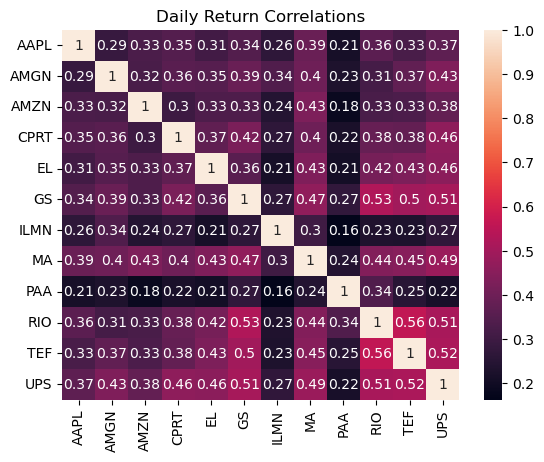

In [55]:
#Plot a seaborn annotated heatmap of the daily return correlations with the title 'Daily Return Correlations'
sns.heatmap(correlations, annot=True)
plt.title("Daily Return Correlations")
plt.show()

#### Save your analysis to multiple excel worksheets
Now that you have completed your analysis, you may want to save all results into a single Excel workbook.

Let's practice exporting various DataFrame to multiple Excel worksheets.

In [56]:
# Inspect index and stock_prices
print(data.info())
print(stock_prices.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   1762 non-null   float64
dtypes: float64(1)
memory usage: 92.1 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1761 non-null   float64
 1   AMGN    1761 non-null   float64
 2   AMZN    1761 non-null   float64
 3   CPRT    1761 non-null   float64
 4   EL      1762 non-null   float64
 5   GS      1762 non-null   float64
 6   ILMN    1761 non-null   float64
 7   MA      1762 non-null   float64
 8   PAA     1762 non-null   float64
 9   RIO     1762 non-null   float64
 10  TEF     1762 non-null   float64
 11  UPS     1762 non-null   float64
dtypes: float64(12)
memory usage: 243.5 KB
None


In [57]:
#Use .join() to combine data with stock_prices, and assign to data
data = stock_prices.join(data)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1761 non-null   float64
 1   AMGN    1761 non-null   float64
 2   AMZN    1761 non-null   float64
 3   CPRT    1761 non-null   float64
 4   EL      1762 non-null   float64
 5   GS      1762 non-null   float64
 6   ILMN    1761 non-null   float64
 7   MA      1762 non-null   float64
 8   PAA     1762 non-null   float64
 9   RIO     1762 non-null   float64
 10  TEF     1762 non-null   float64
 11  UPS     1762 non-null   float64
 12  Index   1762 non-null   float64
dtypes: float64(13)
memory usage: 257.3 KB
None


In [58]:
#Apply .pct_change() to data and assign to returns
returns = data.pct_change()
returns.head()

,AAPL,AMGN,AMZN,CPRT,EL,GS,ILMN,MA,PAA,RIO,TEF,UPS,Index
Date,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001962708537782243,-0.008662508662508617,0.0058999253174010224,0.0,-0.003708281829418847,0.01767968569447631,-0.006546644844517058,-0.002725856697819329,0.011111111111111072,0.015527396037836816,-0.0007005253940455258,0.0017188037126161237,0.004573940828374035
2010-01-06,-0.01599738818152141,-0.007514854945823157,-0.018115673026950718,-0.004395604395604269,0.0028949545078575945,-0.010673328034518037,0.06161449752883019,-0.001952362358453752,-0.000366300366300476,0.030579964850615093,-0.01051524710830698,-0.007378174330816667,-0.004742202819561836
2010-01-07,-0.001990710019907138,-0.009156541644655625,-0.017013232514177745,-0.006622516556291536,0.012783505154638997,0.019568460920463604,0.017070142768466967,-0.006651017214397537,-0.012092341517039307,0.00017053206002737298,-0.017003188097768462,-0.007605877268798689,-0.004957704936516594
2010-01-08,0.0066489361702128935,0.008885729518393282,0.027076923076923,0.004444444444444473,0.004071661237785129,-0.018911465075702072,0.011595971925541404,0.0003938558487592836,0.003338278931750871,0.011082693947144007,-0.006486486486486531,0.048075248214596744,0.00666332374295342


In [60]:
#Create pd.ExcelWriter and use with to export data and returns to excel with sheet_names of the same name.
with pd.ExcelWriter('Datasets/Stock_data-/data.xls') as writer:
    data.to_excel(excel_writer=writer, sheet_name="data")
    returns.to_excel(excel_writer=writer, sheet_name="returns")

C:\Users\Yira Yareth\AppData\Local\Temp\ipykernel_12532\3762272489.py:2: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  with pd.ExcelWriter('Datasets/Stock_data-/data.xls') as writer:
